## Description

This jupyter notebook shows how we can fit a gamma distribution to our data. 
Gamma distribution has two hyper parameters (alpha, beta) while we could draw from
a bivariate posterior distribution, we instead fix alpha and draw beta. 

We justify that by showing that for our data, alpha is quite stable--the shape of 
the pubrev distributions are stable--while beta, which determines the rate, can vary
a lot depending on the input data.

In [1]:
import os

from scipy.optimize import minimize
from scipy.stats import beta, gamma, norm
from scipy.special import gamma as gamma_func

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate

from utils import get_bigquery_result

%matplotlib inline

## Gamma process

Gamma process can be described as a collection of Poisson processes.

We can understand it better with an example. We can think of the process of observing an auction event that resulted in pubrev = x. For each pubrev, however, we have an associated rate of observation. The rate is determined by P(x)dx where P(x) is the gamma distribution. 

Gamma distribution therefore is a compact way of expressing multiple Poisson processes. It also puts in a constraint on rate distribution in that P(x), the rate of occurence, follows the gamma distribution. In real life, the rate of occurence may not be well described by gamma distribution.

### Plot gamma distribution
We plot different gamma distributions with different shape parameter, alpha. We can see that the shape parameter determines whether the distribution 
* (alpha < 1) diverge at x = 0 
* (alpha = 1) has finite y-intercept at x = 0
* (alpha > 1) has zero y-intercept at x = 0

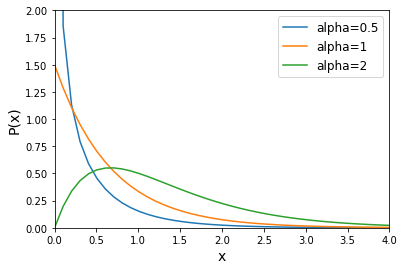

In [2]:
""" Plot the gamma distribution with different shape parameter, alpha """
x = np.linspace(1e-3, 10, 100)
beta = 1.5

fig, ax = plt.subplots(figsize=(6, 4))
for alpha in [0.5, 1, 2]:
    gamma = beta ** alpha / gamma_func(alpha)
    v = gamma * x ** (alpha - 1) * np.exp(-beta * x)
    ax.plot(x, v, label=f"alpha={alpha}")
    
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 2)
    ax.legend(fontsize=12)
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("P(x)", fontsize=14)

## Fitting to data

### Load the data

In [3]:
""" Load the data """
query_template = open("sql/eda_query.sql", "r").read()
params = {
    "start_time": "2021-10-28 12:00:00",
    "end_time": "2021-10-29 12:00:00"
}
sql = query_template.format(**params)
filepath = "input/gamma_distribution_data.csv"

df = get_bigquery_result(sql, filepath=filepath, gcp_project="ox-datascience-devint")

# add cpm_usd column
min_micro_usd = 1
df["cpm_usd"] = (df["pubrev"] + min_micro_usd) / 1e6

Loaded from cached file..


In [4]:
display(df.head())
display(df.describe())

,auction_hour,bidderTimeout,win,pubrev,cpm_usd
0,20,1500,0,0,0.000001
1,20,1500,0,0,0.000001
2,20,1500,0,0,0.000001
3,20,1500,0,0,0.000001
4,20,1500,0,0,0.000001


,auction_hour,bidderTimeout,win,pubrev,cpm_usd
count,506298.000000,506298.000000,506298.000000,5.062980e+05,506298.000000
mean,8.383055,1677.271686,0.128695,2.918649e+05,0.291866
std,5.202186,635.620261,0.334862,1.420844e+06,1.420844
min,0.000000,600.000000,0.000000,0.000000e+00,0.000001
25%,4.000000,1000.000000,0.000000,0.000000e+00,0.000001
50%,8.000000,1500.000000,0.000000,0.000000e+00,0.000001
75%,12.000000,2500.000000,0.000000,0.000000e+00,0.000001
max,23.000000,3000.000000,1.000000,8.133487e+07,81.334870


### Plot beta posterior

In [5]:
""" Plot un-normalized beta posterior distribution """
def plot_beta_posterior(df, alpha=0.5):
    a0 = 2
    b0 = 2
    
    n = len(df)
    sum_x = df["cpm_usd"].sum()
    
    a = alpha * n + a0
    b = b0 / (1 + b0 * sum_x)
      
    beta_left = (a-1) * b * 0.9
    beta_right = (a-1) * b * 1.1
    
    print(f"optimal beta: {(a-1) * b:.3f}")

    betas = np.linspace(beta_left, beta_right, 100)
    exponent = lambda beta: (a-1) * np.log(beta * np.e / (a-1)) - beta / b - a * np.log(b)    
    
    exponents = [exponent(x) for x in betas]
    unscaled_posteriors = np.exp(exponents) / np.sqrt(2 * np.pi * (a-1))
    
    fig, ax = plt.subplots()
    ax.plot(betas, unscaled_posteriors)
    ax.set_xlabel("beta", fontsize=13)
    ax.set_ylabel("P(beta) [arb. unit]", fontsize=13)
    ax.set_title("Beta posterior distribution (not normalized)", fontsize=15)

optimal beta: 0.272


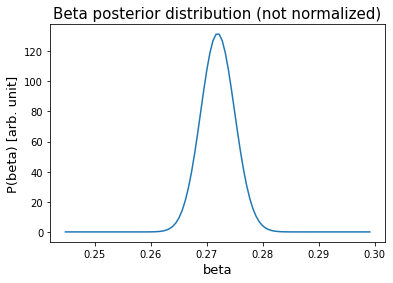

In [6]:
sub_df = df[df["bidderTimeout"] == 1500]
plot_beta_posterior(sub_df, alpha=0.08)

### Plot alpha posterior

In [7]:
""" Plots the log posterior of alpha """
def plot_alpha_log_posterior(df, beta=0.1):
    a0 = 1
    b0 = 1
    c0 = 1
    
    n = len(df)
    prod_x = df["cpm_usd"].prod()
    sum_log_x = np.log(df["cpm_usd"]).sum()
    
    a = a0 * prod_x
    b = b0 + n
    c = c0 + n

    np_log_a = np.log(a0) + sum_log_x

    alphas = np.linspace(0.01, 0.3, 100)

    exponent = lambda alpha: -1 * ((alpha - 1) * np_log_a + alpha * c * np.log(beta) - b * np.log(gamma_func(alpha)))

    print(f"optimal alpha {minimize(exponent, 0.05)['x'][0]:.4f}")
    
    exponents = [exponent(x) for x in alphas]

    fig, ax = plt.subplots()
    ax.plot(alphas, exponents)
    ax.set_xlabel("alpha", fontsize=13)
    ax.set_ylabel("log P(alpha) [arb. unit]", fontsize=13)
    ax.set_title("log alpha posterior distribution (not normalized)", fontsize=15)

optimal alpha 0.0782


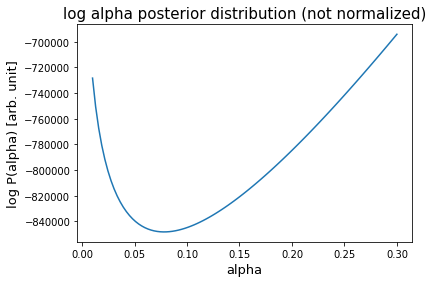

In [8]:
sub_df = df[df["bidderTimeout"] == 1500]
plot_alpha_log_posterior(sub_df, beta=0.272)

### Fit iteratively to get optimal alpha and beta

In [9]:
""" Get optimal alpha. Since there is no analytic solution, we numerically calculate the optimal alpha """
def get_optimal_alpha(df, beta):
    a0 = 1
    b0 = 1
    c0 = 1
    
    n = len(df)
    prod_x = df["cpm_usd"].prod()
    sum_log_x = np.log(df["cpm_usd"]).sum()
    
    b = b0 + n
    c = c0 + n

    np_log_a = np.log(a0) + sum_log_x
    
    exponent = lambda alpha: -1 * ((alpha - 1) * np_log_a + alpha * c * np.log(beta) - b * np.log(gamma_func(alpha)))
    
    return minimize(exponent, 0.05)["x"][0]


In [10]:
""" Get optimal beta. We can differentiate the posterior distribution to get the exact solution """
def get_optimal_beta(df, alpha):
    a0 = 2
    b0 = 2
    
    n = len(df)
    sum_x = df["cpm_usd"].sum()
    
    a = alpha * n + a0
    b = b0 / (1 + b0 * sum_x)
        
    return (a-1) * b

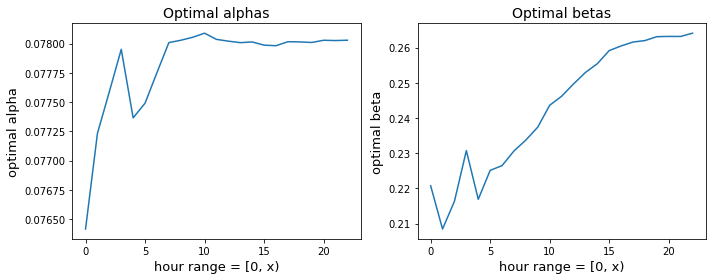

In [11]:
""" Take n hours of data and fit alpha and beta. Confirm that alpha is stable and it's beta that we have to fix """
optimal_betas = []
optimal_alphas = []

df_1500ms = df[df["bidderTimeout"] == 1500]
for hour_lim in range(1, 24):
    hours = [x for x in range(hour_lim)]
    sub_df = df_1500ms[df_1500ms["auction_hour"] < hour_lim]

    optimal_alpha = 0.08
    for _ in range(5):
        optimal_beta = get_optimal_beta(sub_df, alpha=optimal_alpha)
        optimal_alpha = get_optimal_alpha(sub_df, beta=optimal_beta)
    
    optimal_betas.append(optimal_beta)
    optimal_alphas.append(optimal_alpha)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(optimal_alphas)
axes[0].set_title("Optimal alphas", fontsize=14)
axes[1].plot(optimal_betas)
axes[1].set_title("Optimal betas", fontsize=14)
axes[0].set_xlabel("hour range = [0, x)", fontsize=13)
axes[1].set_xlabel("hour range = [0, x)", fontsize=13)
axes[0].set_ylabel("optimal alpha", fontsize=13)
axes[1].set_ylabel("optimal beta", fontsize=13)

fig.tight_layout()

if not os.path.exists("output/"):
    os.mkdir("output")
fig.savefig("output/gamma_distribution_optimal_alpha_beta.png", dpi=150)